# README

This notebook contains the work carried out to answer Question 1 from Shopify's Summer 2022 Data Science Intern Challenge. 

**Question 1**
> On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

# Dependencies Block

In [1]:
# external dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the Dataset

In [2]:
df = pd.read_csv("2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv")
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


# Exploratory Data Analysis (EDA) For Confirmation of Problem Statement
The `df` DataFrame's `.describe()` method is a good starting point for any kind of EDA on numerical tabular data.

In [3]:
df.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


Indeed, we can see the same amount cited in the problem statement: an average order value of `$3145.13`. 

We'll take note of the median of the entire dataset (`$284.00`).

We'll also take the time to check that we are looking at a 30-day window:

In [4]:
pd.to_datetime(df.created_at).max(), \
pd.to_datetime(df.created_at).min(), \
pd.to_datetime(df.created_at).max() - pd.to_datetime(df.created_at).min()

(Timestamp('2017-03-30 23:55:35'),
 Timestamp('2017-03-01 00:08:09'),
 Timedelta('29 days 23:47:26'))

And do some extra sanity-checks:

In [5]:
assert df.order_amount.min() > 0
assert not df.order_id.duplicated().any()

All right! Sanity-checks passed!

## Supplementary EDA

We'll set `order_id`, `shop_id`, and `user_id` aside for now and look at the distribution of the `order_amount` values.

The output of `df.describe()` already raised some questions; the `min`, `25%` (25th percentile), `50%` (50th percentile, the median), and  `75%` (75th percentile) values seem reasonable, but the `mean`, `max`, and `std` (standard deviation) values are orders of magnitude larger! 

Quickly plotting a boxplot for the `order_amount` values confirms that there are outliers in this Series:

Text(0.5, 0.98, 'Distribution of order_amount values')

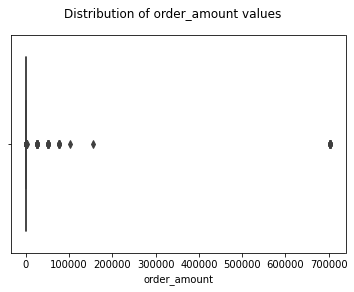

In [6]:
sns.boxplot(df.order_amount)
plt.suptitle("Distribution of order_amount values")

OK! So not only are there a handful of outliers, but one `order_amount` value sticks way out from the rest! These outliers definitely biased the naive AOV calculation upwards, and we'll need to handle them carefully to get an AOV that better represents the typical value of an order.

## Methodology
We'll proceed through the following steps:

1. Defining and identifying outliers
2. Investigating the `order_amount` distribution without outliers
3. Inquiring into the outliers

This is pretty straightforward and linear, so we'll tackle points 1. and 2. first. Since our dataset is so heavily skewed, the z-score approach to identifying outliers is not appropriate. We'll rely on the Interquartie Range (IQR)  method in which an outlier is any data point that lies outside the `[25th quantile - 1.5 * IQR, 75th quantile + 1.5 * IQR]` range.

First let's find the span of the IQR.

In [7]:
IQR = df['order_amount'].quantile(0.75) - df['order_amount'].quantile(0.25)
df['order_amount'].quantile(0.25) - 1.5 * IQR, \
df['order_amount'].quantile(0.75) + 1.5 * IQR, \
IQR

(-177.5, 730.5, 227.0)

We'll then label the orders with `order_amount` values outside the `[25th quantile - 1.5 * IQR, 75th quantile + 1.5 * IQR]` as outliers.

Take note the negation operator.

In [8]:
df['is_outlier'] = ~ df['order_amount'].between(
    df['order_amount'].quantile(0.25) - 1.5 * IQR,
    df['order_amount'].quantile(0.75) + 1.5 * IQR
)
df['is_outlier'].sum()

141

So we identified 141 outliers. Let's see what the `order_amount` operation looks like without them.

Text(0.5, 0.98, 'Box-and-whiskers plot for dataset after excluding outliers')

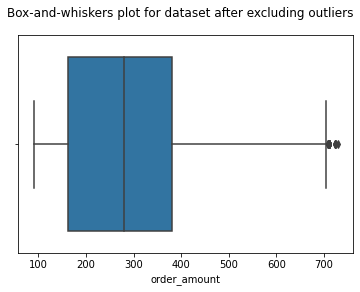

In [9]:
sns.boxplot(df.order_amount[~df.is_outlier.values])
plt.suptitle("Box-and-whiskers plot for dataset after excluding outliers")

Text(0.5, 0.98, 'Box-and-whiskers plot for dataset after excluding outliers')

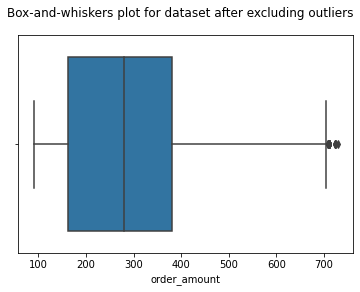

In [10]:
sns.boxplot(df.order_amount[~df.is_outlier.values])
plt.suptitle("Box-and-whiskers plot for dataset after excluding outliers")

In [11]:
df.order_amount[~df.is_outlier.values].describe()

count    4859.000000
mean      293.715374
std       144.453395
min        90.000000
25%       162.000000
50%       280.000000
75%       380.000000
max       730.000000
Name: order_amount, dtype: float64

That distribution seems much more reasonable. The mean (293.72) and median (280.00) are fairly close, and the standard deviation is much less shocking than it was before. 

But let's look into the outliers we identified before jumping to any conclusions.

## Looking Into Outliers

Using the `.describe()` method to quickly summarize the 141 outliers revealed that the smallest outlier (`min = 735.00`) was larger than the largest value in the truncated `order_amount` distribution (`max = 730.00`). So the outliers we've identified strictly represent orders with abnormally large prices. 

In [12]:
df.order_amount[df.is_outlier.values].describe()

count       141.000000
mean     101407.638298
std      225491.524131
min         735.000000
25%         786.000000
50%        1056.000000
75%       51450.000000
max      704000.000000
Name: order_amount, dtype: float64

Visualizing these outliers' distribution is not super informative because they span multiple orders of magnitude.

Text(0.5, 0.98, 'Distribution of 141 Outliers')

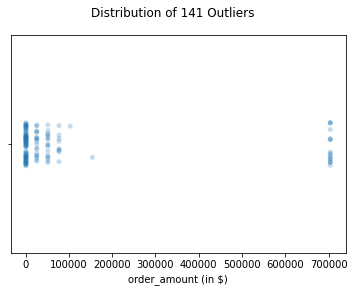

In [13]:
sns.stripplot(
    df.order_amount[df.is_outlier.values].values, 
    alpha=0.25
)
plt.xlabel("order_amount (in $)")
plt.suptitle("Distribution of 141 Outliers")

So we'll transform the outliers' `order_amount` values by taking their natural logarithm (after adding a +1 to handle 0s). We'll also plot the `[25th quantile - 1.5 * IQR, 75th quantile + 1.5 * IQR]` span we used to identify outliers (just to provide additional context).

**NOTE:** Since the `[25th quantile - IQR, 75th quantile + IQR]` range dipped into negative values and we're using a logarithmic x-axis, we'll need to truncate the shaded region to instead cover `[max(0, 25th quantile - 1.5*IQR), 75th quantile + 1.5*IQR]` range. Since all outliers were > 0, this won't affect the interpretation of the plot.

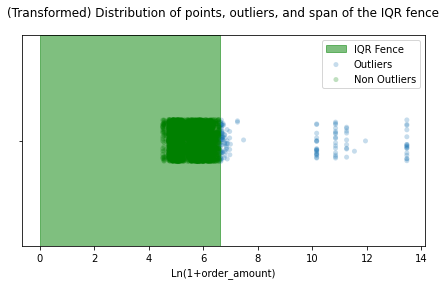

In [14]:
fig, ax = plt.subplots()
ax.axvspan(
    np.log1p(max(df['order_amount'].quantile(0.25) - 1.5*IQR, 0)), 
    np.log1p(df['order_amount'].quantile(0.75) + 1.5*IQR),
    alpha=0.5,
    color='green',
    label="IQR Fence"
)
sns.stripplot(
    np.log1p(df.order_amount[df.is_outlier.values].values),
    ax=ax,
    label="Outliers",
    alpha=0.25
)
sns.stripplot(
    np.log1p(df.order_amount[~df.is_outlier.values].values),
    ax=ax,
    label="Non Outliers",
    alpha=0.25,
    color='green'
)

plt.legend()
plt.xlabel("Ln(1+order_amount)")
plt.suptitle("(Transformed) Distribution of points, outliers, and span of the IQR fence")
plt.tight_layout()

## Conclusions
Exploring the dataset revealed that the `order_amount` values were heavily skewed to the right. This was caused by the presence of outliers, and failing to account for thhem resulted in an AOV value that – while technically correct – clearly did not provide the insight that an AOV value is meant to convey. 

Identifying and excluding these outliers from the dataset would mitigate their impact on the AOV. I chose to do so by using the Interquartile Range (IQR) approach, and identified 141 outliers. The distribution of the remaining 4,859 data points (~97.18% of the original dataset) had a mean, median, and standard deviation of 293.72, 272.00, and 144.45. The fact that the truncated mean (293.72) is close to the truncated median (272.00) and also to the median of the entire dataset (284.00) provides additional support to the claim that the value of interest is in the correct ballpark.

Finally, I would be comfortable using any of the median (`$284.00`), truncated median (`$272.00`), or truncated mean (`$293.72`) as the metric to describe the "typical" `order_amount` value. 